<a href="https://colab.research.google.com/github/atulgupta01/EVA_Group_Assignment/blob/master/P2S1/SessionP2S1_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

## Learning word embeddings with the `Embedding` layer



In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The **Embedding layer** is like a dictionary whih maps words to embedding vectors. 


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [0]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 2s 0us/step


In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 2s 92us/step - loss: 0.6705 - acc: 0.6186 - val_loss: 0.6230 - val_acc: 0.6952
Epoch 2/10
20000/20000 [==============================] - 1s 63us/step - loss: 0.5481 - 

In the above case We get to a validation accuracy of ~76% but problem here is that it considers each words individually not taking into consideration inter-words relationship.

## Using pre-trained word embeddings
In the first case we used pre-tokenized IMDB data. Now we will use pre-trained word embeddings with original IMDB text data.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/My\ Drive/TSAI/P2S1/data

/content/drive/My Drive/TSAI/P2S1/data


### Download the IMDB data as raw text


Download raw IMDB dataset from `http://ai.stanford.edu/~amaas/data/sentiment/` and uncompress it.


In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-03-20 17:27:38--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.4MB/s    in 6.8s    

2020-03-20 17:27:46 (11.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!tar -zxvf aclImdb_v1.tar.gz

In [0]:
import os

imdb_dir = '/content/drive/My Drive/TSAI/P2S1/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data

We use 8000 samples for training and validating on 10000 samples.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 8000  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

In [0]:
!ls

aclImdb  aclImdb_v1.tar.gz


In [0]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-03-20 06:02:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-20 06:02:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-20 06:02:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [0]:
glove_dir = '/content/drive/My Drive/TSAI/P2S1/data/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 264us/step - loss: 0.7280 - acc: 0.6019 - val_loss: 0.6022 - val_acc: 0.6677
Epoch 2/10
8000/8000 [==============================] - 2s 232us/step - loss: 0.6655 - acc: 0.6686 - val_loss: 0.5813 - val_acc: 0.6997
Epoch 3/10
8000/8000 [==============================] - 2s 232us/step - loss: 0.5349 - acc: 0.7457 - val_loss: 0.8611 - val_acc: 0.5928
Epoch 4/10
8000/8000 [==============================] - 2s 245us/step - loss: 0.4647 - acc: 0.7858 - val_loss: 0.5923 - val_acc: 0.6995
Epoch 5/10
8000/8000 [==============================] - 2s 239us/step - loss: 0.3829 - acc: 0.8236 - val_loss: 0.7661 - val_acc: 0.6507
Epoch 6/10
8000/8000 [==============================] - 2s 242us/step - loss: 0.3102 - acc: 0.8709 - val_loss: 0.8937 - val_acc: 0.6472
Epoch 7/10
8000/8000 [==============================] - 2s 238us/step - loss: 0.2647 - acc: 0.8844 - val_loss: 0.8282 - val_acc: 0.6878

Let's plot its performance over time:

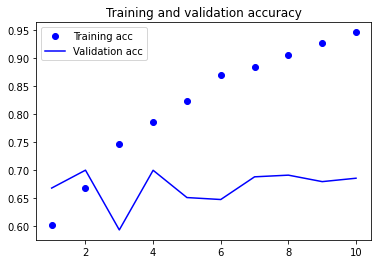

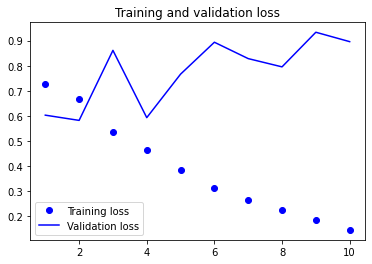

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 60s.

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. Let's try it:

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 4s 562us/step - loss: 0.5379 - acc: 0.7135 - val_loss: 0.4462 - val_acc: 0.7866
Epoch 2/10
8000/8000 [==============================] - 4

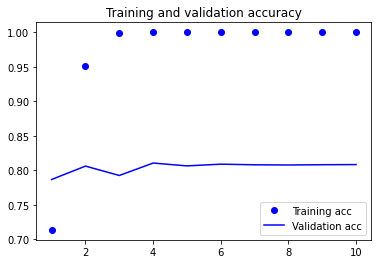

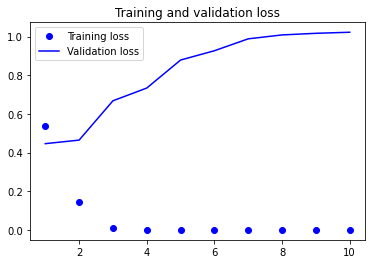

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the 80s.


Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [0]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 48us/step


[0.9053862539100647, 0.68556]

We get an appalling test accuracy of 68%.